In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
DATADIR = Path("data")

In [3]:
from data_processing import *
import data_processing as dp

from train import *

# Correlations
Maybe create a correlation matrix for the dataset, see if staying at home correlates significantly with PHQ9

In [4]:
def preprocessed_data(TYPE="classification", TARGET="value"):
    phq9 = dp.load_phq9_targets(DATADIR / "df_phq9.csv", type=TYPE, target=TARGET)
    locations = load_locations(DATADIR / "df_location_ratio.csv")
    demographics = load_demographics(DATADIR / "df_demographics.csv")
    # mobility = load_passive_mobility(DATADIR / 'df_passive_mobility_features.csv')
    # phone = load_passive_phone(DATADIR / 'df_passive_phone_communication_features_brighten_v2.csv')

    combined, _ = dp.combine(
        phq9,
        dailies=[
            ("locations", locations),
            # ('mobility', mobility),
            # ('phone', phone)
        ],
        constants=[demographics],
        prev_phq9=False,
    )
    combined = dp.rf_preprocess(combined)
    return combined


def plot_correlations(TYPE="classification", TARGET="value", method="pearson"):
    combined = preprocessed_data(TYPE, TARGET)
    corr = combined.iloc[:, 2:]  # remove ID and date
    corr = corr.corr(method=method).iloc[
        0, :
    ]  # take only correlations with target row (first row)
    corr = corr.sort_values(ascending=False)
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr.to_frame(), annot=True, cmap="coolwarm")
    plt.title(f"Correlation in the {TYPE} of PHQ9 {TARGET}")
    plt.show()

## Pearson standard correlation coefficient

In [5]:
combined = []
for i, (TYPE, TARGET) in enumerate(
    [
        ("classification", "value"),
        ("regression", "value"),
        ("classification", "diff"),
        ("regression", "diff"),
    ]
):
    combined.append(preprocessed_data(TYPE, TARGET))

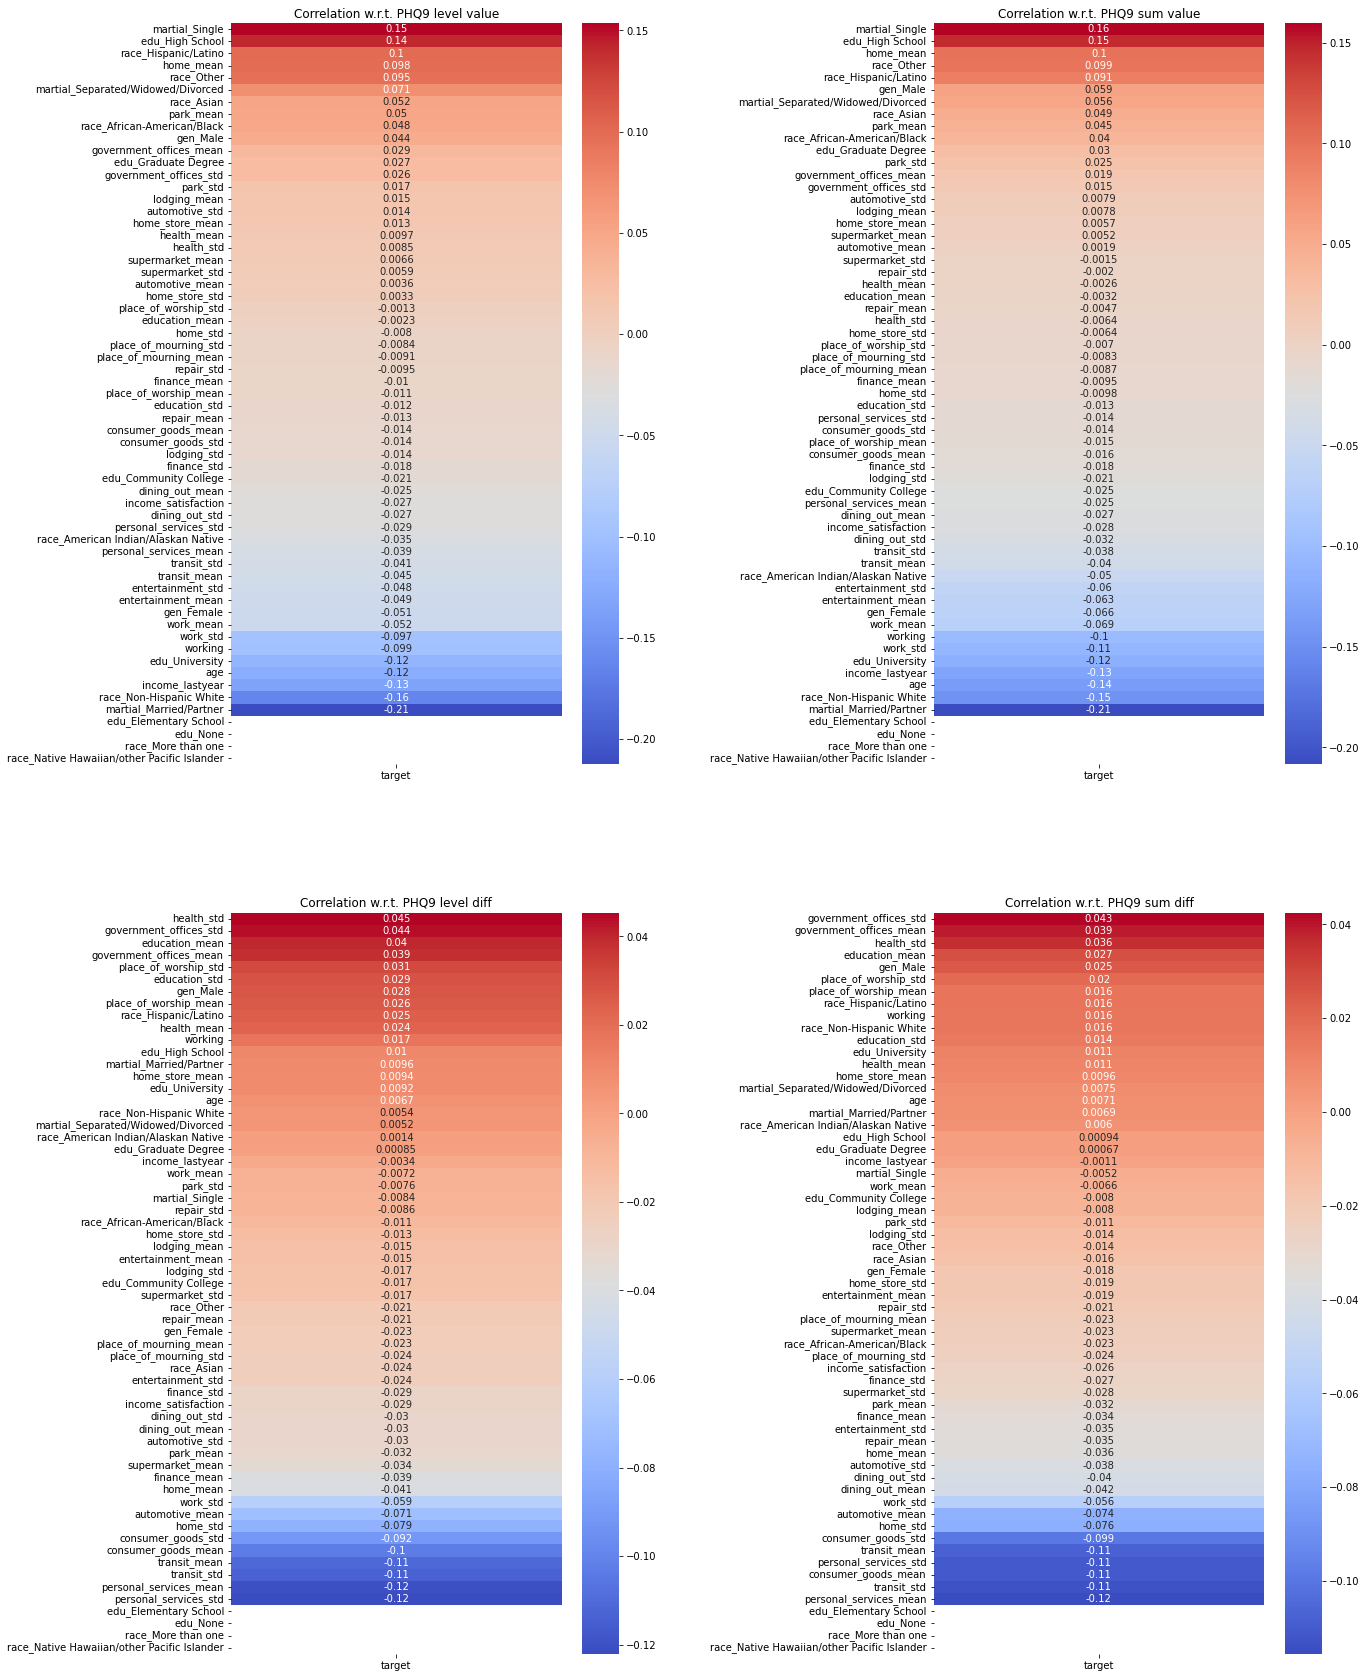

In [6]:
# Create a grid of plots with the four plot_correlations() plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 30))
for i, (TYPE, TARGET) in enumerate(
    [
        ("classification", "value"),
        ("regression", "value"),
        ("classification", "diff"),
        ("regression", "diff"),
    ]
):
    corr = combined[i].iloc[:, 2:]  # remove ID and date
    corr = corr.corr().iloc[0, :]  # take only correlations with target row (first row)
    corr = corr.drop("target").sort_values(
        ascending=False
    )  # correlation with target is always 1.0
    sns.heatmap(corr.to_frame(), annot=True, cmap="coolwarm", ax=axes[i // 2, i % 2])
    type_str = "level" if TYPE == "classification" else "sum"
    axes[i // 2, i % 2].set_title(f"Correlation w.r.t. PHQ9 {type_str} {TARGET}")
    # Increase the horizontal spacing between subplots
    fig.subplots_adjust(wspace=0.7)

## Spearman rank correlation

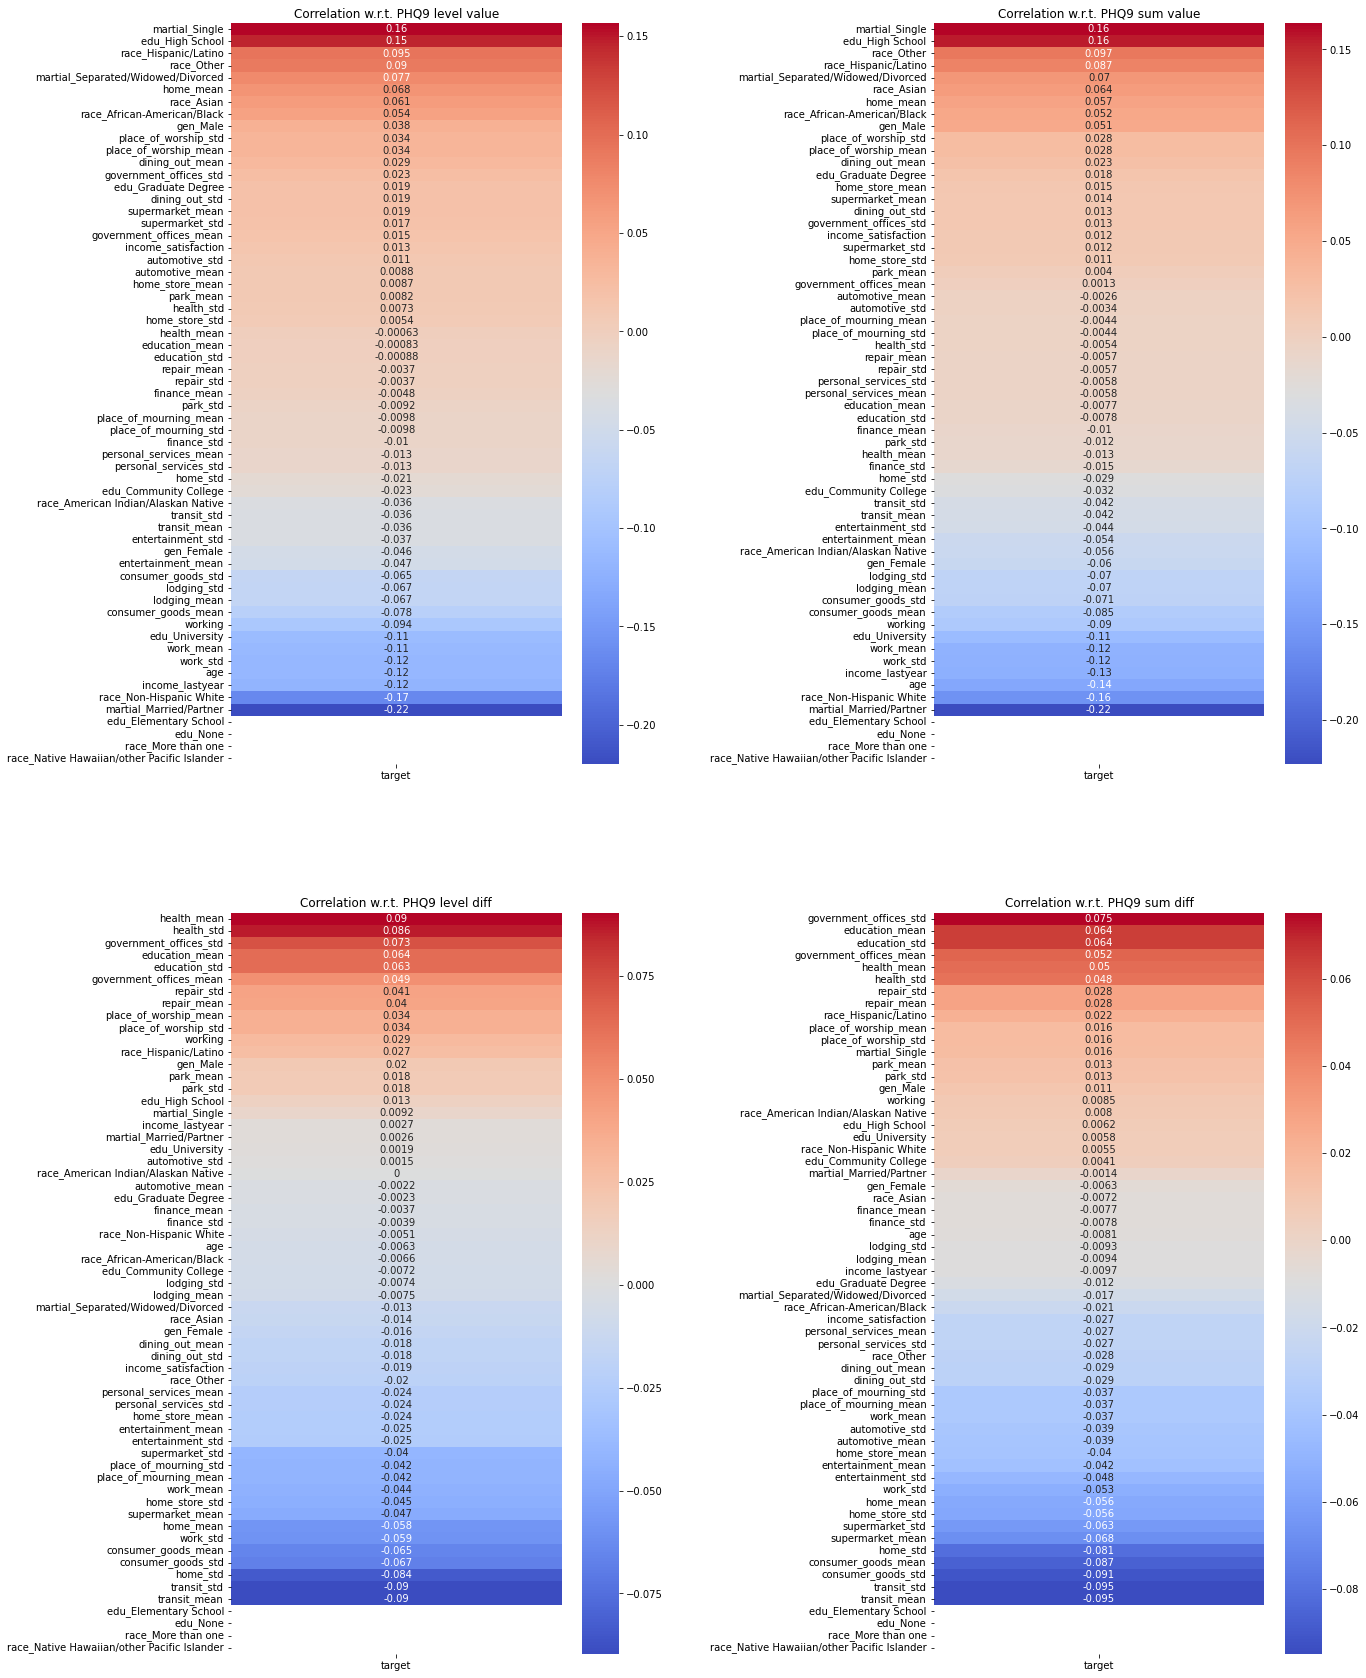

In [7]:
# Create a grid of plots with the four plot_correlations() plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 30))
for i, (TYPE, TARGET) in enumerate(
    [
        ("classification", "value"),
        ("regression", "value"),
        ("classification", "diff"),
        ("regression", "diff"),
    ]
):
    corr = combined[i].iloc[:, 2:]  # remove ID and date
    corr = corr.corr(method="spearman").iloc[
        0, :
    ]  # take only correlations with target row (first row)
    corr = corr.drop("target").sort_values(
        ascending=False
    )  # correlation with target is always 1.0
    sns.heatmap(corr.to_frame(), annot=True, cmap="coolwarm", ax=axes[i // 2, i % 2])
    type_str = "level" if TYPE == "classification" else "sum"
    axes[i // 2, i % 2].set_title(f"Correlation w.r.t. PHQ9 {type_str} {TARGET}")
    # Increase the horizontal spacing between subplots
    fig.subplots_adjust(wspace=0.7)

## p-value

/home/julien/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


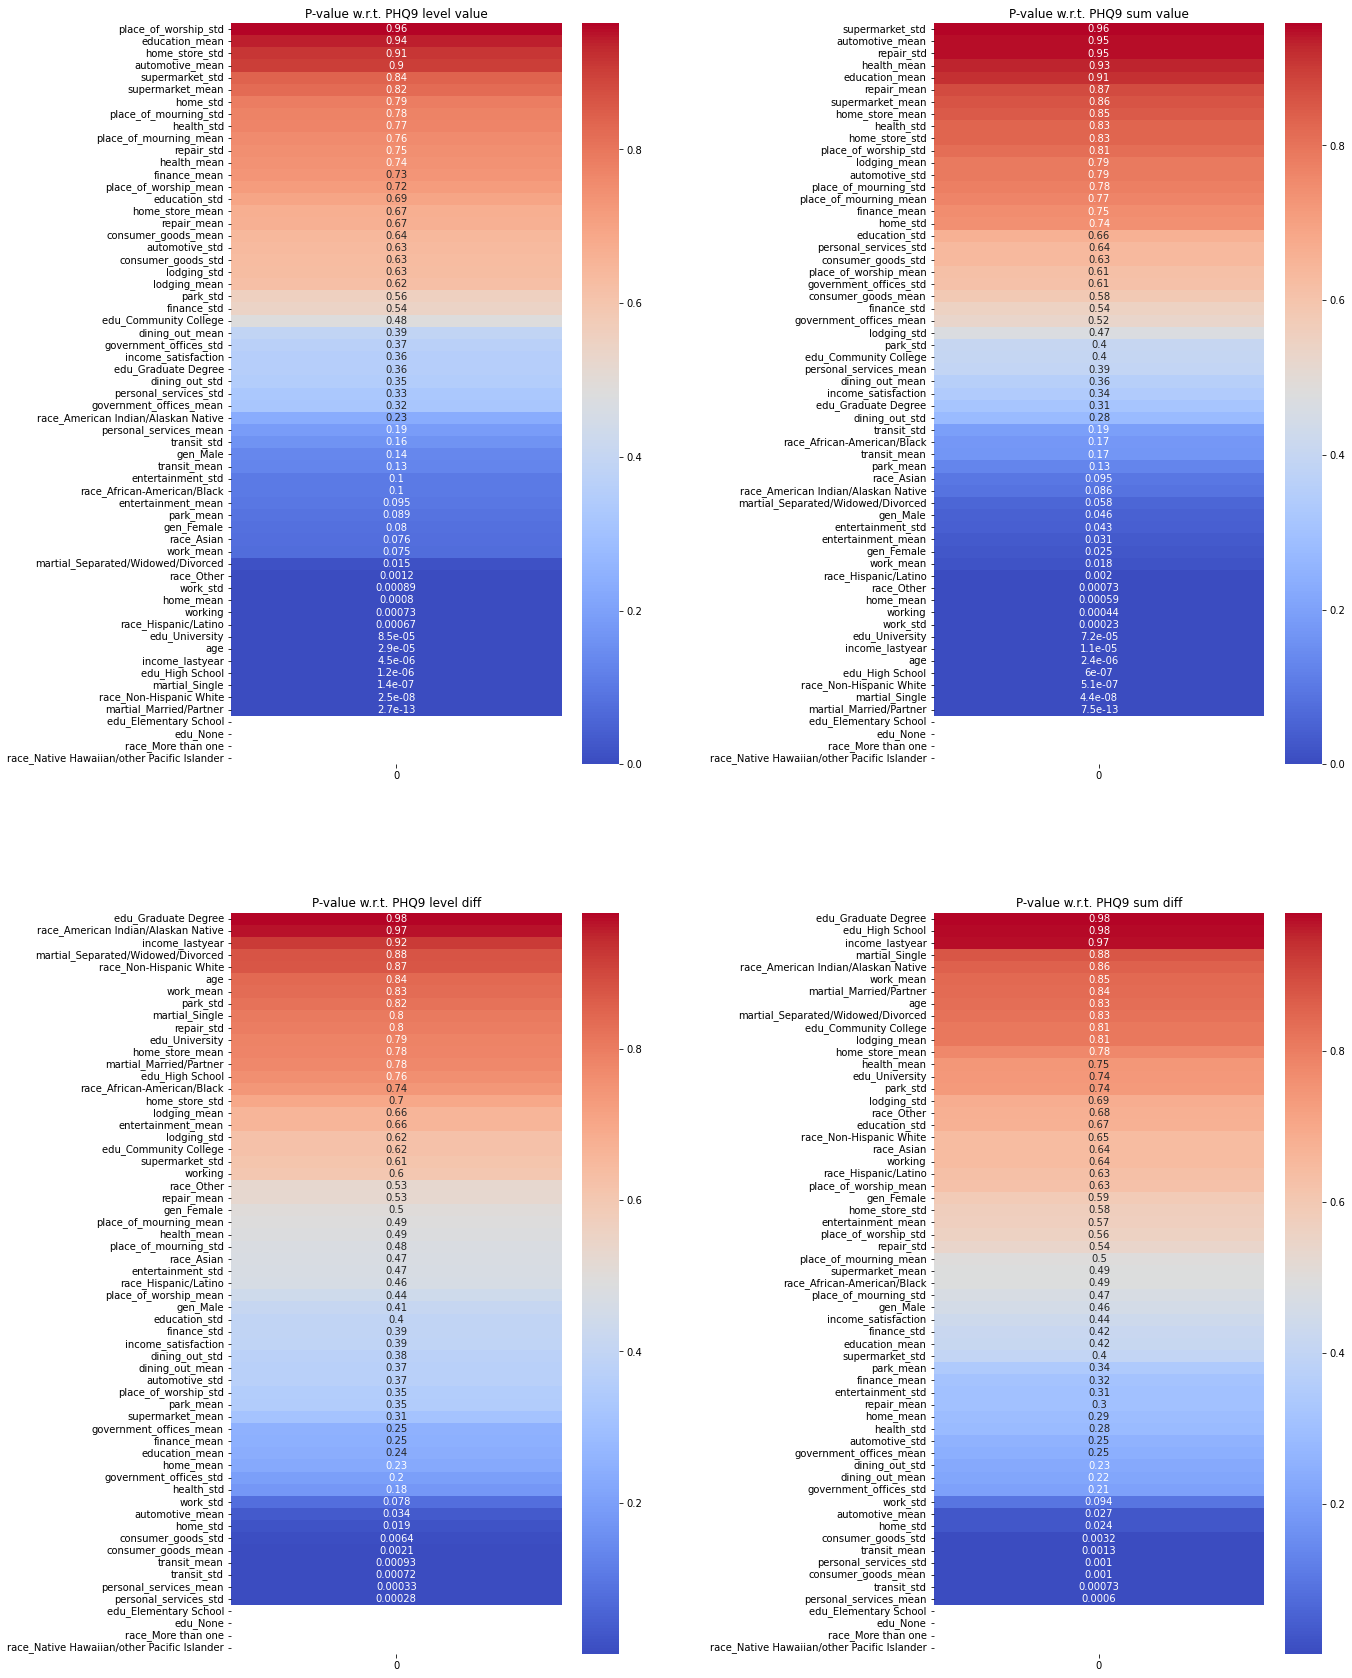

In [8]:
from scipy.stats import pearsonr

# Create a grid of plots with the four plot_correlations() plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 30))
for i, (TYPE, TARGET) in enumerate(
    [
        ("classification", "value"),
        ("regression", "value"),
        ("classification", "diff"),
        ("regression", "diff"),
    ]
):
    combined_i = combined[i]
    columns = combined_i.columns[3:]  # no target, participant_id, date
    pvalues = [pearsonr(combined_i["target"], combined_i[c]).pvalue for c in columns]
    pvalues = pd.Series(pvalues, index=columns)
    pvalues = pvalues.sort_values(ascending=False)

    sns.heatmap(pvalues.to_frame(), annot=True, cmap="coolwarm", ax=axes[i // 2, i % 2])
    type_str = "level" if TYPE == "classification" else "sum"
    axes[i // 2, i % 2].set_title(f"P-value w.r.t. PHQ9 {type_str} {TARGET}")
    # Increase the horizontal spacing between subplots
    fig.subplots_adjust(wspace=0.7)

# Depression levels (classification)


## 5 classes (base)

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train RMSE: 0.3185
Test RMSE:  1.0085
Train score: 94.52%
Test score:  50.29%

After feature selection:
Train set shape: (986, 25)
Test set shape: (175, 25)

Train score: 94.52%
Test score:  53.71%


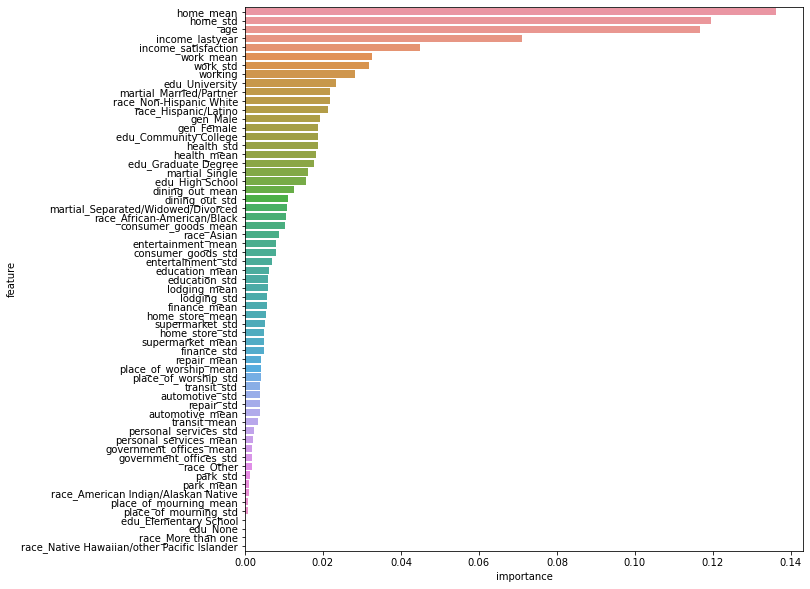

(94.52332657200812, 50.28571428571429, 94.52332657200812, 53.714285714285715)

In [9]:
train(
    TYPE="classification",
    TARGET="value",
    SPLIT_BY_PARTICIPANT=False,
    TEST_TAKE_FIRST=0,
    SEED=550,
    return_csv=False,
    feature_selection=True,
)

## 6 classes (all the classes)
- 0  :   No depression                  195
- 1-4:   Minimal depression             790
- 5-9:   Mild depression                1760
- 10-14: Moderate depression            1111
- 15-19: Moderately severe depression   624
- 20-27: Severe depression              311

In [10]:
partition_list = [
    1
    if i in range(1, 4 + 1)
    else 2
    if i in range(5, 9 + 1)
    else 3
    if i in range(10, 14 + 1)
    else 4
    if i in range(15, 19 + 1)
    else 5
    if i in range(20, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partition = {i: v for i, v in enumerate(partition_list)}

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train RMSE: 0.2568
Test RMSE:  1.0474
Train score: 95.23%
Test score:  45.71%

After feature selection:
Train set shape: (986, 25)
Test set shape: (175, 25)

Train score: 94.52%
Test score:  45.71%


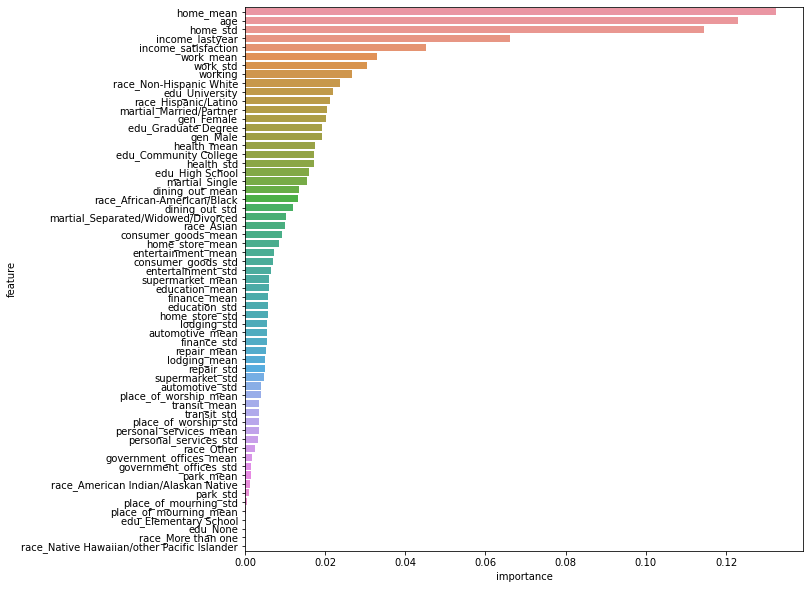

(95.23326572008114, 45.714285714285715, 94.52332657200812, 45.714285714285715)

In [11]:
train(
    TYPE="classification",
    TARGET="value",
    SPLIT_BY_PARTICIPANT=False,
    TEST_TAKE_FIRST=0,
    SEED=550,
    return_csv=False,
    feature_selection=True,
    partition=partition,
)

## 3 classes (the best one)

In [12]:
# Create a list that is 0 for keys 0-4, 1 for keys 5-9, 2 for keys 10-14, 3 for keys 15-27
partition_list = [
    0
    if i in range(0, 4)
    else 1
    if i in range(5, 14 + 1)
    else 2
    if i in range(15, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partition = {i: v for i, v in enumerate(partition_list)}

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train RMSE: 0.1773
Test RMSE:  0.5398
Train score: 96.86%
Test score:  70.86%

After feature selection:
Train set shape: (986, 24)
Test set shape: (175, 24)

Train score: 96.65%
Test score:  71.43%


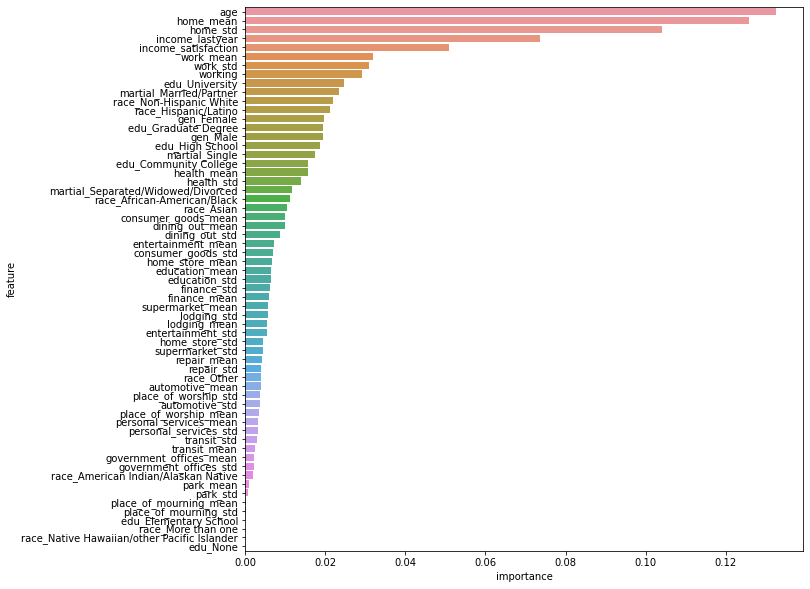

(96.85598377281947, 70.85714285714285, 96.65314401622717, 71.42857142857143)

In [13]:
train(
    TYPE="classification",
    TARGET="value",
    SPLIT_BY_PARTICIPANT=False,
    TEST_TAKE_FIRST=0,
    SEED=550,
    return_csv=False,
    feature_selection=True,
    partition=partition,
)

## 4 classes (mail)
Try 4 classes instead of 5 since the dataset is small:
- **0**:     Class 0 (None)
- **1-9**:   Class 1 (Mild = 1-4: Minimal, 5-9: Mild)
- **10-19**: Class 2 (Moderate = 10-14: Moderate, 15-19: Moderately severe)
- **20-27**: Class 3 (Severe = 20-27: Severe)

In [14]:
# Create a list that is 0 for keys 0, 1 for keys 1-9, 2 for keys 10-19, 3 for keys 20-27
partition_list = [
    0
    if i == 0
    else 1
    if i in range(1, 9 + 1)
    else 2
    if i in range(10, 19 + 1)
    else 3
    if i in range(20, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partition = {i: v for i, v in enumerate(partition_list)}

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train RMSE: 0.2039
Test RMSE:  0.6094
Train score: 96.45%
Test score:  69.71%

After feature selection:
Train set shape: (986, 24)
Test set shape: (175, 24)

Train score: 96.15%
Test score:  66.29%


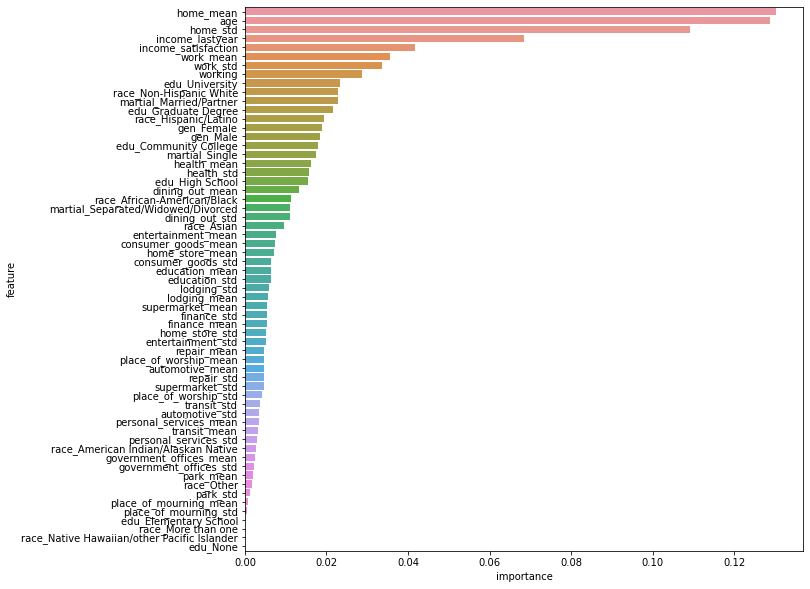

(96.45030425963489, 69.71428571428572, 96.14604462474645, 66.28571428571428)

In [15]:
train(
    TYPE="classification",
    TARGET="value",
    SPLIT_BY_PARTICIPANT=False,
    TEST_TAKE_FIRST=0,
    SEED=550,
    return_csv=False,
    feature_selection=True,
    partition=partition,
)

## 4 classes

In [16]:
# Create a list that is 0 for keys 0-4, 1 for keys 5-9, 2 for keys 10-14, 3 for keys 15-27
partition_list = [
    0
    if i in range(0, 4)
    else 1
    if i in range(5, 9 + 1)
    else 2
    if i in range(10, 14 + 1)
    else 3
    if i in range(15, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partition = {i: v for i, v in enumerate(partition_list)}

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train RMSE: 0.2340
Test RMSE:  0.9008
Train score: 95.74%
Test score:  57.14%

After feature selection:
Train set shape: (986, 24)
Test set shape: (175, 24)

Train score: 95.13%
Test score:  59.43%


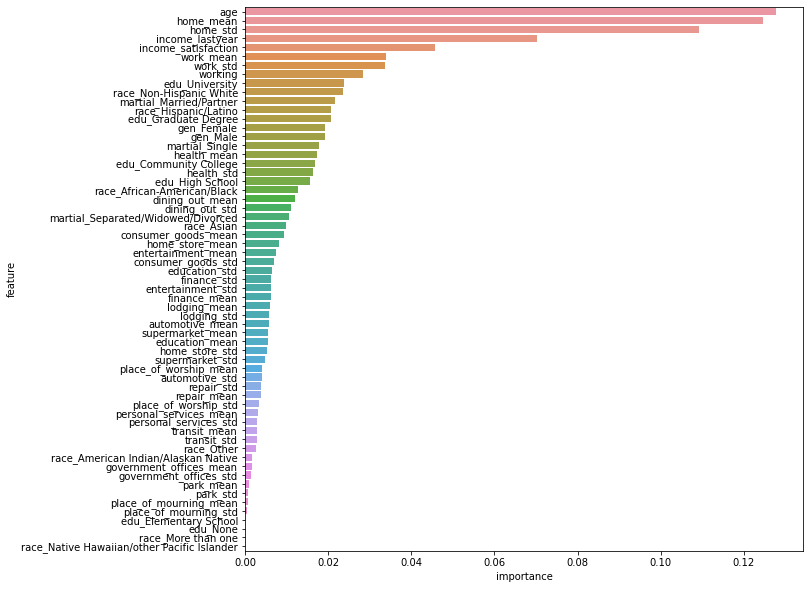

(95.74036511156187, 57.14285714285714, 95.131845841785, 59.42857142857143)

In [17]:
train(
    TYPE="classification",
    TARGET="value",
    SPLIT_BY_PARTICIPANT=False,
    TEST_TAKE_FIRST=0,
    SEED=550,
    return_csv=False,
    feature_selection=True,
    partition=partition,
    verbose=True,
)

## Plots

In [18]:
partitions = []
partition_list = [
    0
    if i in range(0, 4)
    else 1
    if i in range(5, 14 + 1)
    else 2
    if i in range(15, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partitions.append({i: v for i, v in enumerate(partition_list)})

partition_list = [
    0
    if i == 0
    else 1
    if i in range(1, 9 + 1)
    else 2
    if i in range(10, 19 + 1)
    else 3
    if i in range(20, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partitions.append({i: v for i, v in enumerate(partition_list)})


partition_list = [
    0
    if i in range(0, 4)
    else 1
    if i in range(5, 9 + 1)
    else 2
    if i in range(10, 14 + 1)
    else 3
    if i in range(15, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partitions.append({i: v for i, v in enumerate(partition_list)})

partitions.append(None)


partition_list = [
    1
    if i in range(1, 4 + 1)
    else 2
    if i in range(5, 9 + 1)
    else 3
    if i in range(10, 14 + 1)
    else 4
    if i in range(15, 19 + 1)
    else 5
    if i in range(20, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partitions.append({i: v for i, v in enumerate(partition_list)})

In [19]:
def stats(
    partitions, SPLIT_BY_PARTICIPANT=False, TEST_TAKE_FIRST=0, SEED=550, verbose=True
):
    train_scores = []
    test_scores = []
    train_scores_sel = []
    test_scores_sel = []
    datas = []

    for partition in partitions:
        res = train(
            TYPE="classification",
            TARGET="value",
            SPLIT_BY_PARTICIPANT=SPLIT_BY_PARTICIPANT,
            TEST_TAKE_FIRST=TEST_TAKE_FIRST,
            SEED=SEED,
            return_csv=True,
            feature_selection=True,
            partition=partition,
            verbose=False,
        )
        train_scores.append(res[0])
        test_scores.append(res[1])
        train_scores_sel.append(res[2])
        test_scores_sel.append(res[3])
        datas.append(res[4])

    df = pd.DataFrame(
        {
            "partition": [
                "0-4, 5-14, 15-27",
                "0, 1-9, 10-19, 20-27",
                "0-4, 5-9, 10-14, 15-27",
                "base",
                "0, 1-4, 5-9, 10-14, 15-19, 20-27",
            ],
            "train": train_scores,
            "test": test_scores,
            "train (fs)": train_scores_sel,
            "test (fs)": test_scores_sel,
        }
    )

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    for i, data in enumerate(datas):
        axs[i].pie(
            data["target"].value_counts(),
            labels=data["target"].value_counts().index,
            autopct="%1.1f%%",
        )
        axs[i].set_title(df["partition"][i])
    plt.show()

    df1 = df.melt(id_vars="partition", var_name="set", value_name="accuracy")
    sns.barplot(x="partition", y="accuracy", hue="set", data=df1)
    plt.show()

    return df

### ̀SPLIT_BY_PARTICIPANT=False, TEST_TAKE_FIRST=0 (default)

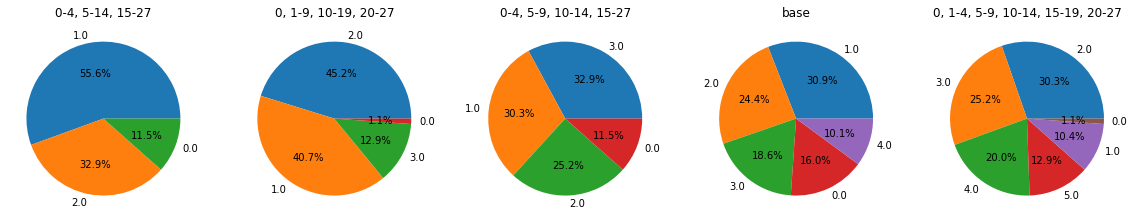

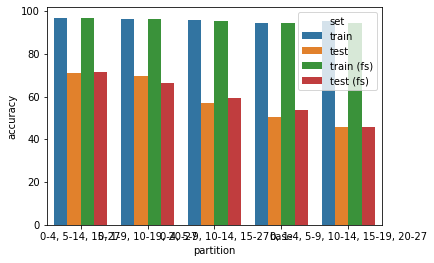

,partition,train,test,train (fs),test (fs)
0,"0-4, 5-14, 15-27",96.855984,70.857143,96.653144,71.428571
1,"0, 1-9, 10-19, 20-27",96.450304,69.714286,96.146045,66.285714
2,"0-4, 5-9, 10-14, 15-27",95.740365,57.142857,95.131846,59.428571
3,base,94.523327,50.285714,94.523327,53.714286
4,"0, 1-4, 5-9, 10-14, 15-19, 20-27",95.233266,45.714286,94.523327,45.714286


In [20]:
df = stats(partitions, SPLIT_BY_PARTICIPANT=False, TEST_TAKE_FIRST=0)
df

- 0  :   No depression                  195
- 1-4:   Minimal depression             790
- 5-9:   Mild depression                1760
- 10-14: Moderate depression            1111
- 15-19: Moderately severe depression   624
- 20-27: Severe depression              311

### ̀```SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=0```

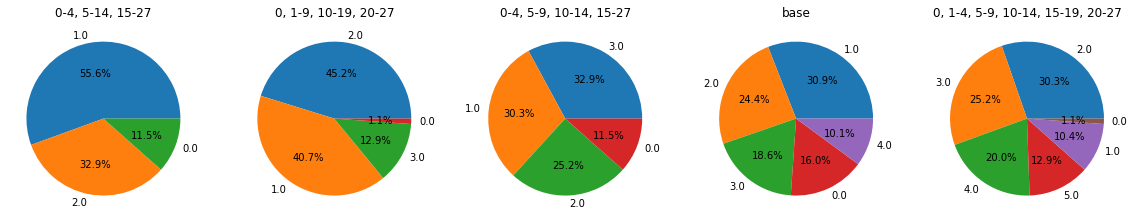

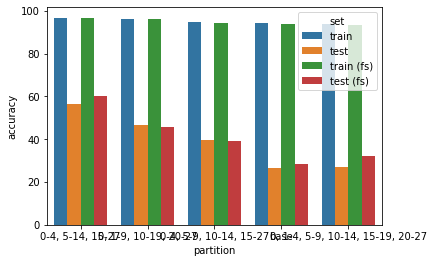

,partition,train,test,train (fs),test (fs)
0,"0-4, 5-14, 15-27",96.800826,56.250000,96.594427,60.416667
1,"0, 1-9, 10-19, 20-27",96.284830,46.875000,95.975232,45.833333
2,"0-4, 5-9, 10-14, 15-27",94.943240,39.583333,94.530444,39.062500
3,base,94.117647,26.562500,93.911249,28.645833
4,"0, 1-4, 5-9, 10-14, 15-19, 20-27",93.808050,27.083333,93.292054,32.291667


In [21]:
df = stats(partitions, SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=0)
df

### ̀```SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=1```

After test_take_first=1, have 89.06% (285) vs. 10.94 (35) participants in train/test set
After test_take_first=1, have 89.06% (285) vs. 10.94 (35) participants in train/test set
After test_take_first=1, have 89.06% (285) vs. 10.94 (35) participants in train/test set
After test_take_first=1, have 89.06% (285) vs. 10.94 (35) participants in train/test set
After test_take_first=1, have 89.06% (285) vs. 10.94 (35) participants in train/test set


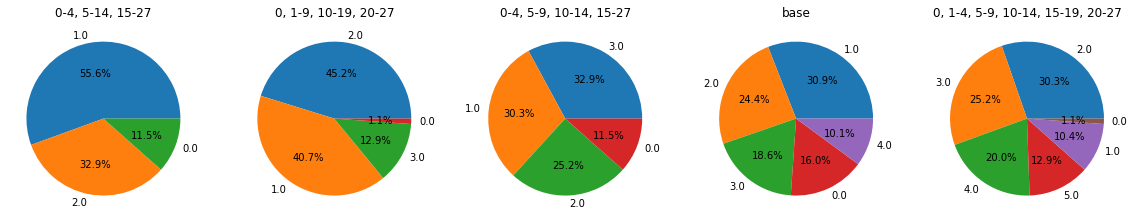

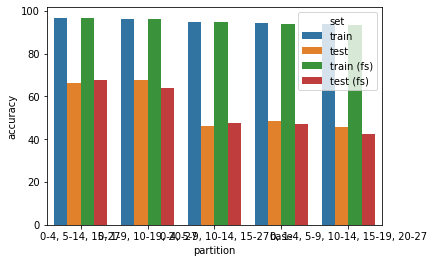

,partition,train,test,train (fs),test (fs)
0,"0-4, 5-14, 15-27",96.837945,66.442953,96.640316,67.785235
1,"0, 1-9, 10-19, 20-27",96.343874,67.785235,96.047431,63.758389
2,"0-4, 5-9, 10-14, 15-27",95.059289,46.308725,94.664032,47.651007
3,base,94.268775,48.322148,93.873518,46.979866
4,"0, 1-4, 5-9, 10-14, 15-19, 20-27",93.972332,45.637584,93.478261,42.281879


In [22]:
df = stats(partitions, SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=1)
df

### ̀```SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=2```

After test_take_first=2, have 90.76% (285) vs. 9.24 (29) participants in train/test set
After test_take_first=2, have 90.76% (285) vs. 9.24 (29) participants in train/test set
After test_take_first=2, have 90.76% (285) vs. 9.24 (29) participants in train/test set
After test_take_first=2, have 90.76% (285) vs. 9.24 (29) participants in train/test set
After test_take_first=2, have 90.76% (285) vs. 9.24 (29) participants in train/test set


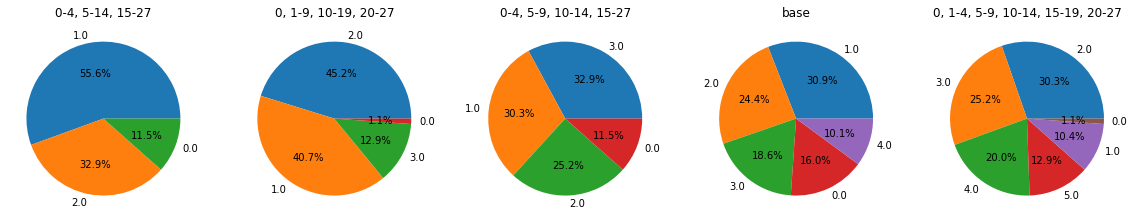

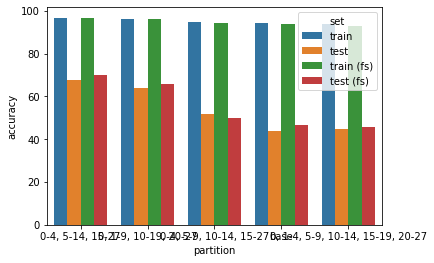

,partition,train,test,train (fs),test (fs)
0,"0-4, 5-14, 15-27",96.752627,67.543860,96.466094,70.175439
1,"0, 1-9, 10-19, 20-27",96.275072,64.035088,95.988539,65.789474
2,"0-4, 5-9, 10-14, 15-27",94.842407,51.754386,94.364852,50.000000
3,base,94.173830,43.859649,93.791786,46.491228
4,"0, 1-4, 5-9, 10-14, 15-19, 20-27",93.791786,44.736842,93.027698,45.614035


In [23]:
df = stats(partitions, SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=2)
df

### ̀```SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=3```

After test_take_first=3, have 93.44% (285) vs. 6.56 (20) participants in train/test set
After test_take_first=3, have 93.44% (285) vs. 6.56 (20) participants in train/test set
After test_take_first=3, have 93.44% (285) vs. 6.56 (20) participants in train/test set
After test_take_first=3, have 93.44% (285) vs. 6.56 (20) participants in train/test set
After test_take_first=3, have 93.44% (285) vs. 6.56 (20) participants in train/test set


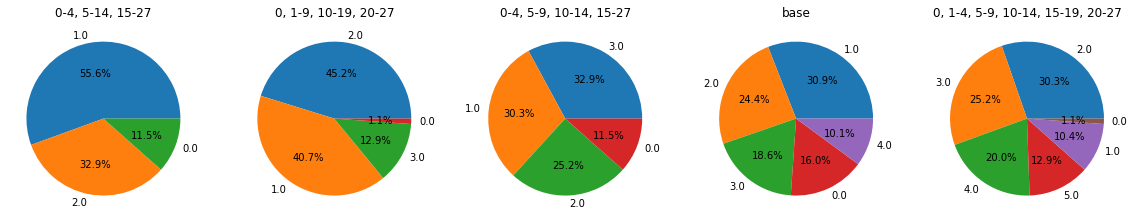

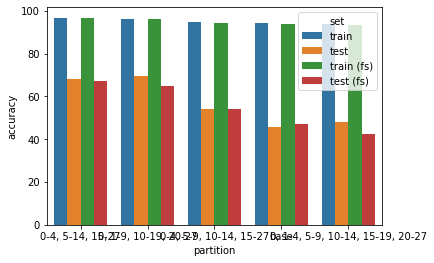

,partition,train,test,train (fs),test (fs)
0,"0-4, 5-14, 15-27",96.840149,68.235294,96.561338,67.058824
1,"0, 1-9, 10-19, 20-27",96.375465,69.411765,96.096654,64.705882
2,"0-4, 5-9, 10-14, 15-27",94.981413,54.117647,94.330855,54.117647
3,base,94.330855,45.882353,93.959108,47.058824
4,"0, 1-4, 5-9, 10-14, 15-19, 20-27",93.959108,48.235294,93.215613,42.352941


In [24]:
df = stats(partitions, SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=3)
df

### ̀```SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=4```

After test_take_first=4, have 94.06% (285) vs. 5.94 (18) participants in train/test set
After test_take_first=4, have 94.06% (285) vs. 5.94 (18) participants in train/test set
After test_take_first=4, have 94.06% (285) vs. 5.94 (18) participants in train/test set
After test_take_first=4, have 94.06% (285) vs. 5.94 (18) participants in train/test set
After test_take_first=4, have 94.06% (285) vs. 5.94 (18) participants in train/test set


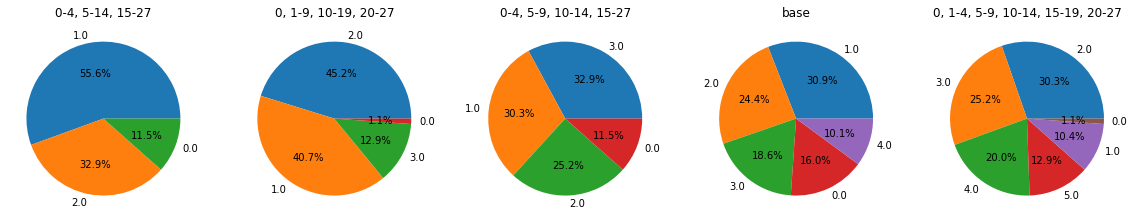

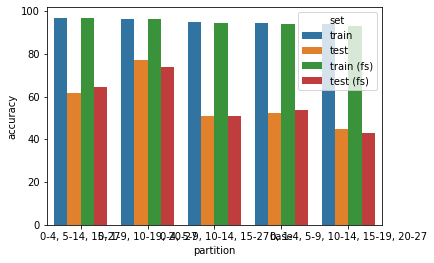

,partition,train,test,train (fs),test (fs)
0,"0-4, 5-14, 15-27",96.897810,61.538462,96.624088,64.615385
1,"0, 1-9, 10-19, 20-27",96.350365,76.923077,96.076642,73.846154
2,"0-4, 5-9, 10-14, 15-27",94.981752,50.769231,94.343066,50.769231
3,base,94.343066,52.307692,93.978102,53.846154
4,"0, 1-4, 5-9, 10-14, 15-19, 20-27",93.978102,44.615385,93.248175,43.076923


In [25]:
df = stats(partitions, SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=4)
df

### All combinations

In [26]:
train_scores = []
test_scores = []
train_scores_sel = []
test_scores_sel = []
datas = []
splits_by_participant = []
test_take_first = []

# Outer loop for splits by participant (False, True) and test take first (0,1,2,3,4)
for SPLIT_BY_PARTICIPANT in [False, True]:
    for TEST_TAKE_FIRST in range(0, 4 + 1):
        for partition in partitions:
            res = train(
                TYPE="classification",
                TARGET="value",
                SPLIT_BY_PARTICIPANT=SPLIT_BY_PARTICIPANT,
                TEST_TAKE_FIRST=TEST_TAKE_FIRST,
                SEED=550,
                return_csv=True,
                feature_selection=True,
                partition=partition,
                verbose=False,
            )
            train_scores.append(res[0])
            test_scores.append(res[1])
            train_scores_sel.append(res[2])
            test_scores_sel.append(res[3])
            datas.append(res[4])
            splits_by_participant.append(SPLIT_BY_PARTICIPANT)
            test_take_first.append(TEST_TAKE_FIRST)

df = pd.DataFrame(
    {
        "partition": [
            "0-4, 5-14, 15-27",
            "0, 1-9, 10-19, 20-27",
            "0-4, 5-9, 10-14, 15-27",
            "base",
            "0, 1-4, 5-9, 10-14, 15-19, 20-27",
        ],
        "train": train_scores,
        "test": test_scores,
        "train (fs)": train_scores_sel,
        "test (fs)": test_scores_sel,
        "SPLIT": splits_by_participant,
        "TTF": test_take_first,
    }
)
df

KeyboardInterrupt: 